In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
abbreviations = {
    "post_ablation": "post abl.",
}

def format_name(name: str):
    return name.replace("_", " ").capitalize()


In [3]:
def forestplot(ax, ts, xlabel="Distribution of posterior samples"):
    az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3, hdi_prob=0.95);
    ax.axvline(0.0, linestyle="--", color="black");
    xlow, xhigh = ax.get_xlim();
    xbiggest = max(abs(xlow), abs(xhigh))
    ax.set_xlim(-xbiggest, xbiggest);
    ax.set(title="", xlabel=xlabel);
    return ax

## Whisker stimulation (Figure 2)

In [4]:
whisker_idata = az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-ind", "idata"))

Prob: 0.65025


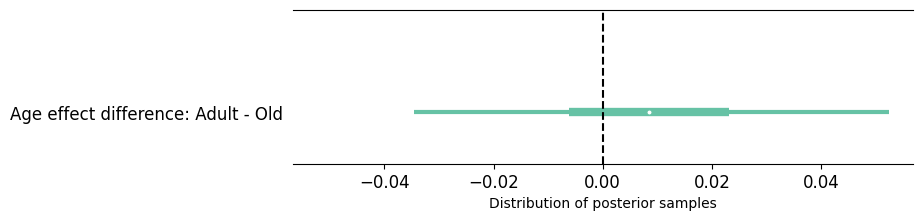

In [5]:
t = whisker_idata.posterior["mu"].sel(age="adult") - whisker_idata.posterior["mu"].sel(age="old")

f, ax = plt.subplots(figsize=[8,2])
forestplot(ax, {"Age effect difference: Adult - Old": t});
save_figure(f, "main-f2-whisker-age")
print("Prob: " + str((t>0).mean().item()))

### Caption for above figure

Thin green line: posterior 94% highest density interval for difference in age effect on whisker stimulation response in our statistical model. Thick green line: posterior 25% and 75% quartiles.
Dot: posterior mean.

These results indicate that, according to our model, there is no clear effect of age on whisker stimulation response. The posterior probability that adults have generally higher response is approximately 65%.


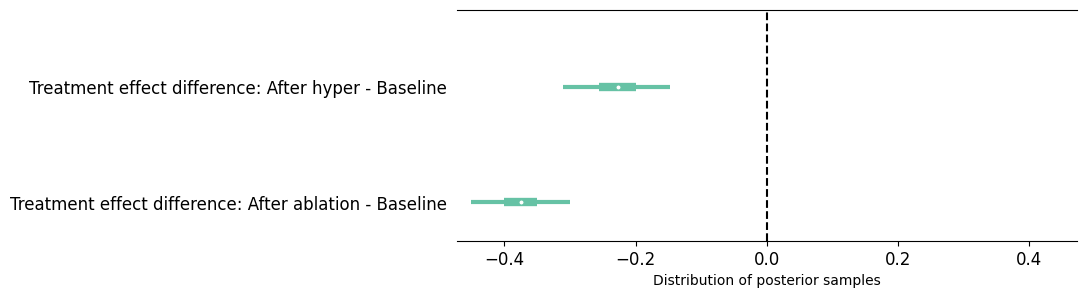

In [6]:
ts = {
    f"Treatment effect difference: {format_name(treatment)} - Baseline": (
        whisker_idata.posterior["a_treatment"].sel(treatment=treatment)
        - whisker_idata.posterior["a_treatment"].sel(treatment="baseline")
    )
    for treatment in ["after_hyper", "after_ablation"]
}
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, ts);
save_figure(f, "main-f2-whisker-treatment")


## Hypertensive challenge (figure 3)

In [7]:
hyper_data = load_prepared_data("../data/prepared/hypertension.json")
hyper_idata = az.InferenceData.from_zarr(os.path.join("..", "inferences", "hypertension-basic", "idata"))

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Probs:
{'Age effect difference: Adult - Old': 0.01025, 'Treatment effect difference: Hyper2 - Hyper1': 1.0}


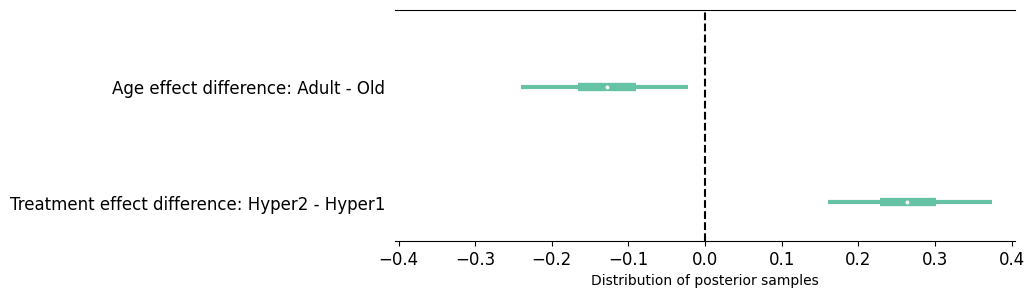

In [8]:
ts = {}
prs = {}

for param_name, coord, (a, b) in zip(
    ["mu", "a_treatment"], 
    ["age", "treatment"],
    [("adult", "old"), ("hyper2", "hyper1")]
):
    t = hyper_idata.posterior[param_name].sel({coord: a}) - hyper_idata.posterior[param_name].sel({coord: b})
    name = f"{coord.capitalize()} effect difference: {a.capitalize()} - {b.capitalize()}"
    ts[name] = t
    prs[name] = (t > 0).mean().values[()]

f, ax = plt.subplots(figsize=[8, 3])
ax = forestplot(ax, ts);
save_figure(f, "main-f3-hypertension")
print("Probs:")
print(prs)

## RBC flow (figure 4)

In [9]:
idatas_flow = {
    "speed": az.from_zarr(os.path.join("..", "inferences", "flow-basic-speed", "idata")),
    "flux": az.from_zarr(os.path.join("..", "inferences", "flow-basic-flux", "idata"))
}

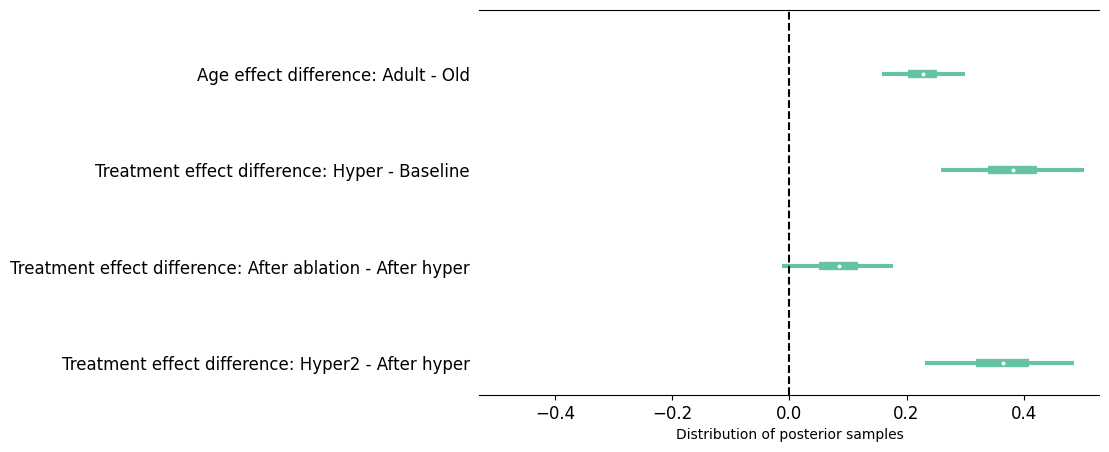

In [10]:
idata = idatas_flow["speed"]

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
}
ts_treatment = {
    f"Treatment effect difference: {format_name(after)} - {format_name(before)}": (
        idata.posterior["a_treatment"].sel(treatment=after) 
        - idata.posterior["a_treatment"].sel(treatment=before)
    )
    for before, after in [("baseline", "hyper"), ("after_hyper", "after_ablation"), ("after_hyper", "hyper2")]
}
ts = ts_age | ts_treatment

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f4-flow-velocity")


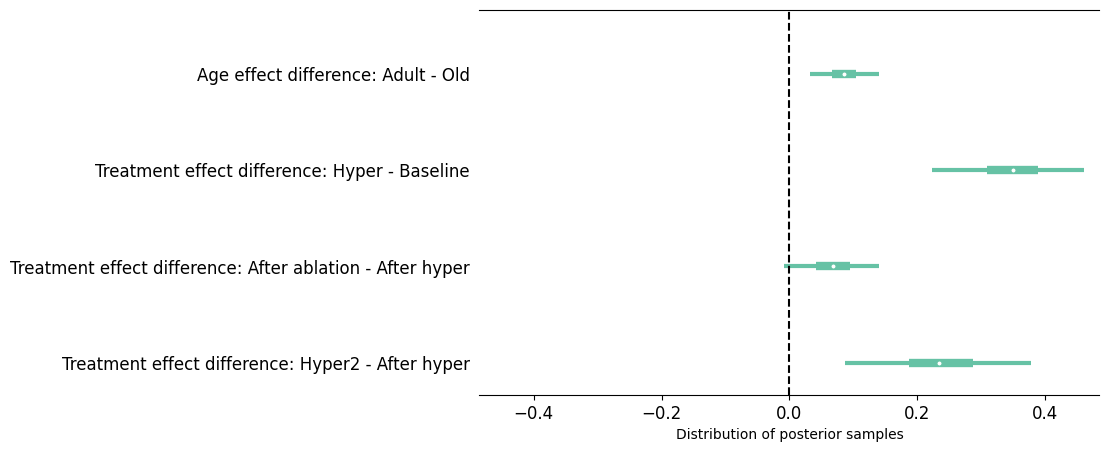

In [11]:
idata = idatas_flow["flux"]

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
}
ts_treatment = {
    f"Treatment effect difference: {format_name(after)} - {format_name(before)}": (
        idata.posterior["a_treatment"].sel(treatment=after) 
        - idata.posterior["a_treatment"].sel(treatment=before)
    )
    for before, after in [("baseline", "hyper"), ("after_hyper", "after_ablation"), ("after_hyper", "hyper2")]
}
ts = ts_age | ts_treatment

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f4-flow-flux")


## Pulsatility (Figure 5)

In [12]:
idata_f5 = az.from_zarr(os.path.join("..", "inferences", "pulsatility-basic-full", "idata"))

{'Age effect difference: Adult - Old': 1.0, 'Treatment effect difference: Ablation - After hyper': 0.961, 'Treatment effect difference: After hyper - baseline': 0.94325, 'Treatment effect difference: Hyper 2 - After ablation': 0.08325}


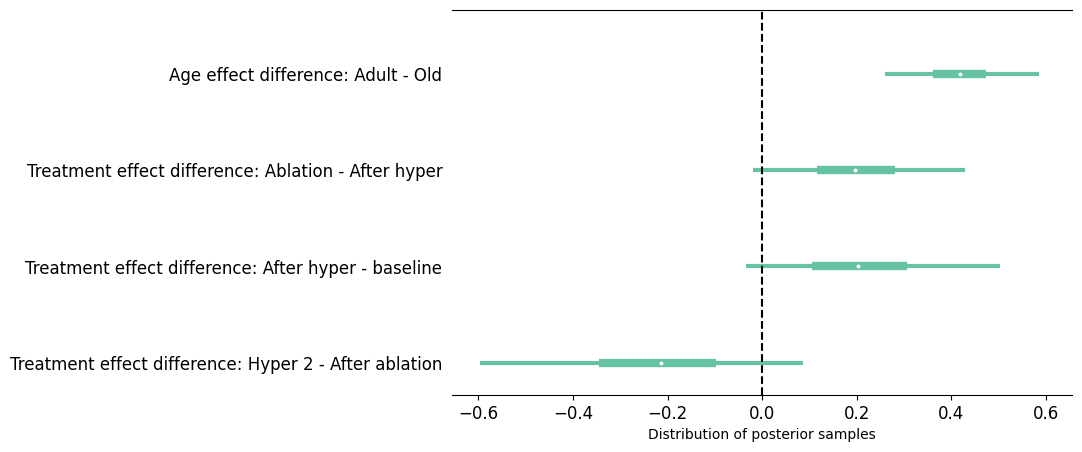

In [13]:
idata = idata_f5
mt = "diameter"

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult", measurement_type=mt) - idata.posterior["mu"].sel(age="old", measurement_type=mt)
}
ts_abl_ahc = {
    f"Treatment effect difference: Ablation - After hyper": (
        idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt)
    )
}
ts_ahc_baseline = {
    f"Treatment effect difference: After hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_h2_aabl = {
    f"Treatment effect difference: Hyper 2 - After ablation": (
        idata.posterior["a_treatment"].sel(treatment="hyper2", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt)
    )
}

ts = ts_age | ts_abl_ahc | ts_ahc_baseline | ts_h2_aabl


f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f5-pulsatility-diameter")
print({k: (v > 0).mean().item() for k, v in ts.items()})

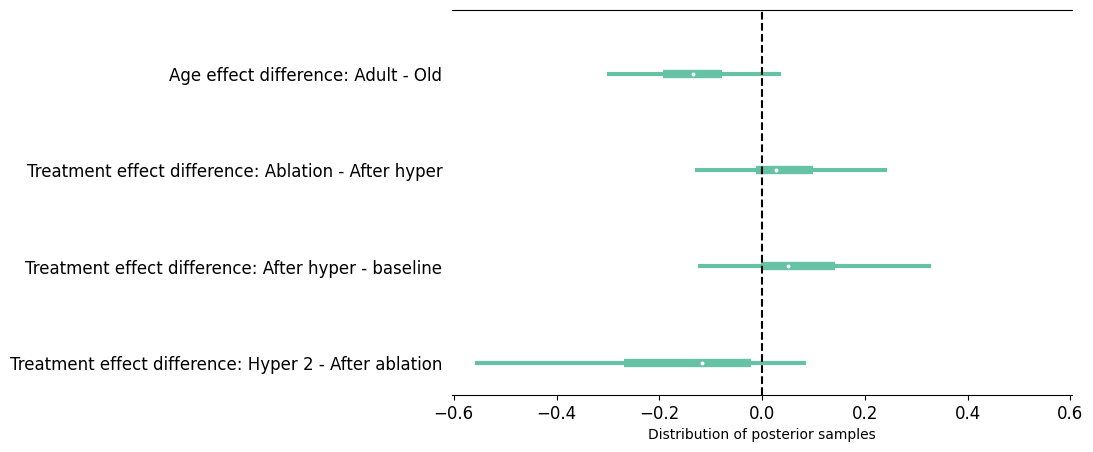

In [14]:
idata = idata_f5
mt = "center"

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult", measurement_type=mt) - idata.posterior["mu"].sel(age="old", measurement_type=mt)
}
ts_abl_ahc = {
    f"Treatment effect difference: Ablation - After hyper": (
        idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt)
    )
}
ts_ahc_baseline = {
    f"Treatment effect difference: After hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_h2_aabl = {
    f"Treatment effect difference: Hyper 2 - After ablation": (
        idata.posterior["a_treatment"].sel(treatment="hyper2", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt)
    )
}

ts = ts_age | ts_abl_ahc | ts_ahc_baseline | ts_h2_aabl

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f5-pulsatility-center")

## capillary density (Figure 6)

In [15]:
idata_f6_density = az.InferenceData.from_zarr("../inferences/density/idata")
idata_f6_tortuosity = az.InferenceData.from_zarr("../inferences/tortuosity/idata")
idata_f6_sphincter = az.from_netcdf("../inferences/branchpoints/is_sphincter.nc")
idata_f6_bulb = az.from_netcdf("../inferences/branchpoints/is_bulb.nc")
idata_f6_collatterals = az.from_netcdf("../inferences/collaterals/ctls_per_area.nc")

In [16]:
idata_f6_collatterals

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

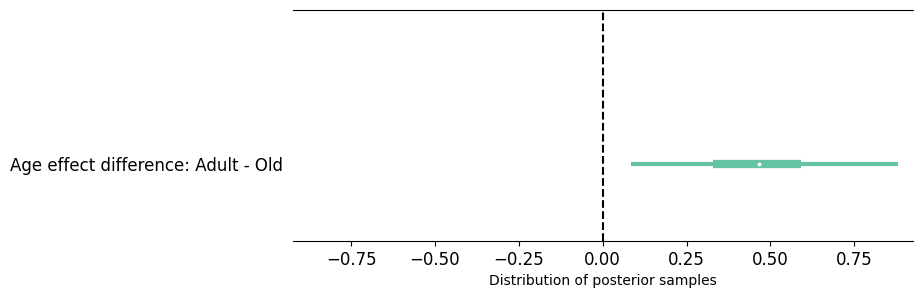

In [17]:
idata = idata_f6_collatterals

ts = {
    f"Age effect difference: Adult - Old": -idata.posterior["age"]
}
f, ax = plt.subplots(figsize=[8, 3])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-collateral-density-age")

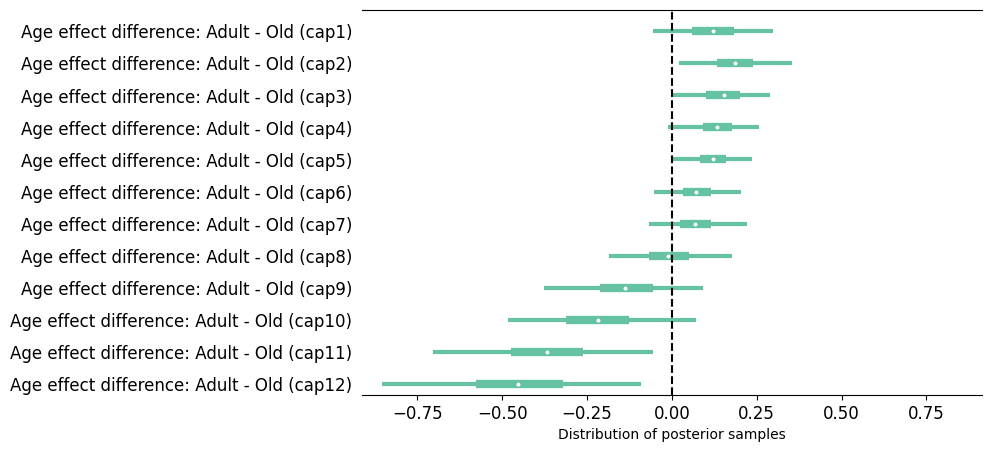

In [18]:
idata = idata_f6_density

ts = {
    f"Age effect difference: Adult - Old ({vt})": (
        idata.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata.posterior.coords["vessel_type"].values
}
f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-density-age-vt")

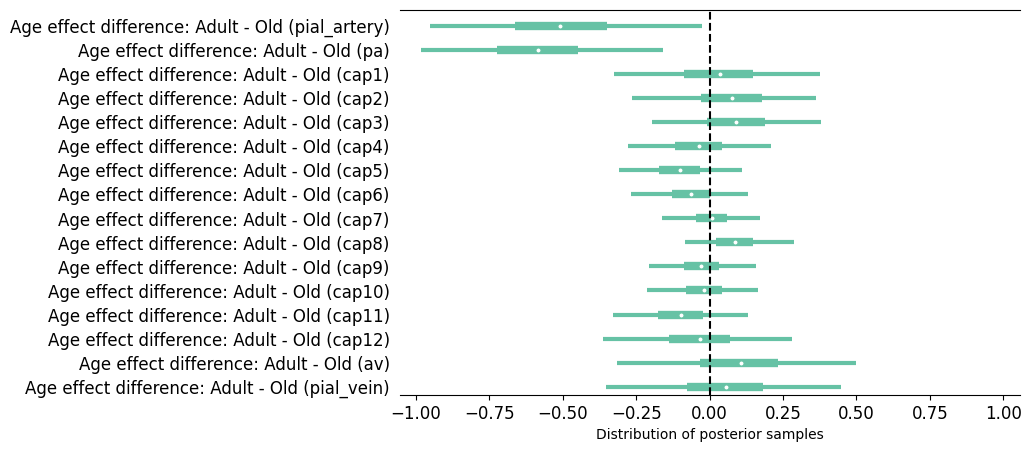

In [19]:
idata = idata_f6_tortuosity

ts = {
    f"Age effect difference: Adult - Old ({vt})": (
        idata.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata.posterior.coords["vessel_type"].values
}
f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-tortuosity-age-vt")

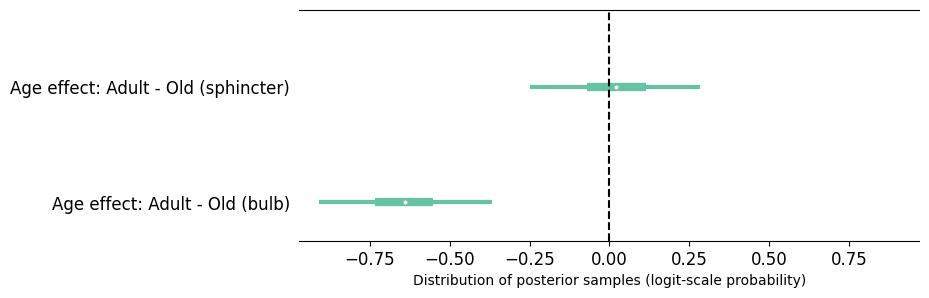

In [21]:
ts = {
    "Age effect: Adult - Old (sphincter)": -idata_f6_sphincter.posterior["age"],
    "Age effect: Adult - Old (bulb)": -idata_f6_bulb.posterior["age"],
}

f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, ts);
ax.set_xlabel(ax.get_xlabel() + " (logit-scale probability)");
save_figure(f, "main-f6-sphincter-and-bulb")